# 3a. Prepare group snapshots from patient snapshots

Collecting patient snapshots together into a group snapshot is useful when predicting a bed count distribution at a point in time. A group snapshot is a subset of patients who were in the ED on a single snapshot date, at a specific prediction time.

In this notebook, I show how `patientflow` can be used to prepare group snapshots for current patients, by dividing patient snapshots into their groups, and storing the group snapshots as dictionary with:
* `snapshot_date` as the key
* `snapshot_ids` of each patient snapshot as the values 

This structure is a convenient way to organise the data when making bed count predictions for different snapshot dates and prediction times, and especially when evaluating those predictions (see next notebook).

## About the examples in this notebook

In this notebook I use fake data that resemble visits to the Emergency Department (ED). The dataset covers mutiple snapshot dates and prediction times.

To start with a very simple example, I apply a series of Bernoulli trials to one group snapshot and visualise the bed count distribution reflecting the sum of these trials. In that simple example, every patient has the same probability of the outcome.

I then train a model that predicts a probability of admission for each patient within a group snapshot. This is a more realistic example, as each patient can have a different probability of admission, based on their data. I apply Bernoulli trials and again visualise the predicted distribution for the total number of beds needed for those patients. 

I demonstrate functions in `patientflow` that handle the preparation of group snapshots for making predictions. 

In [1]:
# Reload functions every time
%load_ext autoreload 
%autoreload 2

## Generate fake snapshots

See [a previous notebook](2a_Create_patient_snapshots.ipynb) for more background on this. 

In [2]:
from patientflow.generate import create_fake_snapshots

prediction_times = [(6, 0), (9, 30), (12, 0), (15, 30), (22, 0)] 
snapshots_df=create_fake_snapshots(prediction_times=prediction_times, 
                                   start_date='2023-01-01', 
                                   end_date='2023-04-01',
                                   mean_patients_per_day=100)
snapshots_df.head()


,snapshot_date,prediction_time,patient_id,visit_number,is_admitted,age,latest_triage_score,num_bmp_orders,num_cbc_orders,num_urinalysis_orders,num_troponin_orders,num_d-dimer_orders
snapshot_id,,,,,,,,,,,,
0,2023-01-01,"(6, 0)",5453,34,0,36,4.0,1,0,0,0,0
1,2023-01-01,"(6, 0)",270,1,0,47,5.0,0,1,0,0,0
2,2023-01-01,"(9, 30)",5453,34,0,36,4.0,1,0,0,0,0
3,2023-01-01,"(9, 30)",5294,27,0,36,3.0,1,1,0,1,1
4,2023-01-01,"(9, 30)",5274,79,0,26,4.0,0,0,0,0,0


Note that each record in the snapshots dataframe is indexed by a unique snapshot_id. 

## Prepare group snapshots

`patientflow` includes a `prepare_group_snapshot_dict()` function. As input, it requires a pandas dataframe with a `snapshot_date` column. If a start date and end date are provided, the function will check for any intervening snapshot dates that are missing, and create an empty group snapshot for this date

Here I create a group snapshot dictionary, for patients in the ED at 09.30.


In [3]:
from patientflow.prepare import prepare_group_snapshot_dict

# select the snapshots to include in the probability distribution, 
group_snapshots_dict = prepare_group_snapshot_dict(
    snapshots_df[snapshots_df.prediction_time == (9,30)]
    )

The keys of the dictionary are the `snapshot_date`. The values are a list of patients in the ED at that time, identified by their unique `snapshot_id`.


In [4]:
print("First 10 keys in the snapshots dictionary")
print(list(group_snapshots_dict.keys())[0:10])


First 10 keys in the snapshots dictionary
[datetime.date(2023, 1, 1), datetime.date(2023, 1, 2), datetime.date(2023, 1, 3), datetime.date(2023, 1, 4), datetime.date(2023, 1, 5), datetime.date(2023, 1, 6), datetime.date(2023, 1, 7), datetime.date(2023, 1, 8), datetime.date(2023, 1, 9), datetime.date(2023, 1, 10)]


From the first key in the dictionary, we can see the patients belonging to this first snapshot. 

In [5]:
first_group_snapshot_key = list(group_snapshots_dict.keys())[0]
first_group_snapshot_values = group_snapshots_dict[first_group_snapshot_key]

print(f"\nThere are {len(first_group_snapshot_values)} patients in the first group snapshot")

print("\nUnique snapshot_ids in the first group snapshot:")
print(first_group_snapshot_values)

# print("\nPatient snapshots belonging to the first group snapshot:")
# snapshots_df.loc[first_group_snapshot_values]


There are 11 patients in the first group snapshot

Unique snapshot_ids in the first group snapshot:
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


We can use the indices to identify the full patient snapshots. 

In [6]:
snapshots_df.loc[first_group_snapshot_values]

,snapshot_date,prediction_time,patient_id,visit_number,is_admitted,age,latest_triage_score,num_bmp_orders,num_cbc_orders,num_urinalysis_orders,num_troponin_orders,num_d-dimer_orders
snapshot_id,,,,,,,,,,,,
2,2023-01-01,"(9, 30)",5453,34,0,36,4.0,1,0,0,0,0
3,2023-01-01,"(9, 30)",5294,27,0,36,3.0,1,1,0,1,1
4,2023-01-01,"(9, 30)",5274,79,0,26,4.0,0,0,0,0,0
5,2023-01-01,"(9, 30)",6917,18,1,45,3.0,1,0,0,0,0
6,2023-01-01,"(9, 30)",4234,43,0,98,4.0,1,0,1,0,0
7,2023-01-01,"(9, 30)",7613,69,0,46,4.0,1,0,0,0,0
8,2023-01-01,"(9, 30)",4665,83,1,45,3.0,1,1,0,1,1
9,2023-01-01,"(9, 30)",6012,32,0,22,4.0,0,0,1,0,0
10,2023-01-01,"(9, 30)",6846,6,0,40,4.0,0,0,0,0,0


 More useful is to return not just the indices, but also the data for each visit in the group snapshot. This can be done with the `prepare_patient_snapshots`, which makes the data ready for processing in groups. This will:

 * filter visits to include only those at the requested prediction time
 * randomly select one snapshot per visit, if requested. If `single_snapshot_per_visit` is set to True, a `visit_col` argument must be used, giving the name of the column containing visit identifiers
 * return a tuple of (X, y) matrices, ready for inference. The column containing the outcome (ie the label) is specified in the `label_col` argument.  

In [7]:
from patientflow.prepare import prepare_patient_snapshots

first_snapshot_X, first_snapshot_y = prepare_patient_snapshots(
    df=snapshots_df.loc[first_group_snapshot_values], 
    prediction_time=(9,30),
    single_snapshot_per_visit=False,
    label_col="is_admitted"
)
first_snapshot_X

,snapshot_date,prediction_time,patient_id,visit_number,age,latest_triage_score,num_bmp_orders,num_cbc_orders,num_urinalysis_orders,num_troponin_orders,num_d-dimer_orders
snapshot_id,,,,,,,,,,,
2,2023-01-01,"(9, 30)",5453,34,36,4.0,1,0,0,0,0
3,2023-01-01,"(9, 30)",5294,27,36,3.0,1,1,0,1,1
4,2023-01-01,"(9, 30)",5274,79,26,4.0,0,0,0,0,0
5,2023-01-01,"(9, 30)",6917,18,45,3.0,1,0,0,0,0
6,2023-01-01,"(9, 30)",4234,43,98,4.0,1,0,1,0,0
7,2023-01-01,"(9, 30)",7613,69,46,4.0,1,0,0,0,0
8,2023-01-01,"(9, 30)",4665,83,45,3.0,1,1,0,1,1
9,2023-01-01,"(9, 30)",6012,32,22,4.0,0,0,1,0,0
10,2023-01-01,"(9, 30)",6846,6,40,4.0,0,0,0,0,0


## Simple example of making a prediction for a group snapshot

Let's make some predictions for this group. We'll give each of them a probability of being admitted of 0.2. This is equivalent to computing the probable outcome of 12 coin flips, with probability of heads of 0.2.

In [8]:
from scipy import stats
prob_dist_data = stats.binom.pmf(range(13), 12, 0.2)
prob_dist_data


array([6.87194767e-02, 2.06158430e-01, 2.83467842e-01, 2.36223201e-01,
       1.32875551e-01, 5.31502203e-02, 1.55021476e-02, 3.32188877e-03,
       5.19045120e-04, 5.76716800e-05, 4.32537600e-06, 1.96608000e-07,
       4.09600000e-09])

We can plot the predicted distribution using the `plot_prob_dist` function from patientflow.viz

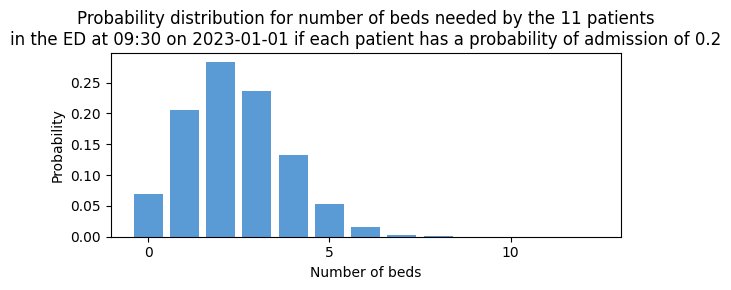

In [9]:
prob_admission_first_group_snapshot = 0.2*len(first_group_snapshot_values)

from patientflow.viz.probability_distribution import plot_prob_dist
from patientflow.viz.utils import format_prediction_time
title = (
    f'Probability distribution for number of beds needed by the '
    f'{len(first_group_snapshot_values)} patients\n'
    f'in the ED at {format_prediction_time((9,30))} '
    f'on {first_group_snapshot_key} if each patient has a probability of admission of 0.2'
)
plot_prob_dist(prob_dist_data, title,  
    include_titles=True)

## Example of making a prediction for a group snapshot with varying probabilities for each patient

In the cell below, I'm using `create_temporal_splits()` to create a training, validation and test set and `train_classifier()` to prepare a XGBoost classifier. This classifier will be used to generate a predicted probability of admission for each patient. See the [2b_Predict_using_patient_snapshots](2b_Predict_using_patient_snapshots.ipynb) notebook for more on the functions shown here.

In [10]:
from datetime import date   
from patientflow.prepare import create_temporal_splits
from patientflow.train.classifiers import train_classifier

# set the temporal split
start_training_set = date(2023, 1, 1) 
start_validation_set = date(2023, 2, 15) # 6 week training set 
start_test_set = date(2023, 3, 1) # 2 week validation set 
end_test_set = date(2023, 4, 1) # 1 month test set

# create the temporal splits
train_visits, valid_visits, test_visits = create_temporal_splits(
    snapshots_df,
    start_training_set,
    start_validation_set,
    start_test_set,
    end_test_set,
    col_name="snapshot_date", # states which column contains the date, for use when making the splits 
    patient_id="patient_id", # states which column contains the patient id, for use when making the splits 
    visit_col="visit_number", # states which column contains the visit number to use when making the splits 

)
# exclude columns that are not needed for training
exclude_from_training_data=['visit_number', 'snapshot_date', 'prediction_time']

# train the patient-level model
model = train_classifier(
    train_visits,
    valid_visits,
    test_visits=test_visits,
    grid={"n_estimators": [30]},
    prediction_time=(9, 30),
    exclude_from_training_data=exclude_from_training_data,
    ordinal_mappings={'latest_triage_score': [1, 2, 3, 4, 5]},
    visit_col='visit_number',
    use_balanced_training=True,
    calibrate_probabilities=True
)



Patient Set Overlaps (before random assignment):
Train-Valid: 0 of 5318
Valid-Test: 102 of 3690
Train-Test: 307 of 6129
All Sets: 0 of 7364 total patients
Split sizes: [6406, 2122, 4304]


Now, using the trained model, I will predict a bed count distribution for one snapshot using `get_prob_dist_for_prediction_moment()`. That function expects the following: 

* `X_test` - the dataset of patient snapshots to be passed to the model
* `y_test` - the vector containing the outcome for each patient snapshot (if these are known)
* `model` - a trained model
* `inference_time` (defaults to True) - if set to False, the function will calculate the observed outcome for the group snapshot; set this to True if the outcomes for each patient as as yet unknown
* `weights` - an optional parameter to weight the probabilities returned by the model. This will be demonstrated in later examples

The function returns a dictionary with two keys:

* `agg_predicted` contains a predicted probability distribution - in this example, for number of admissions among the patients in the snapshot
* `agg_observed` counts the number of times the outcome was observed - in this case number of admissions observed

In [11]:
from patientflow.aggregate import get_prob_dist_for_prediction_moment

bed_count_prob_dist = get_prob_dist_for_prediction_moment(
    first_snapshot_X, 
    model, 
    inference_time=False, 
    y_test=first_snapshot_y
)

bed_count_prob_dist.keys()


dict_keys(['agg_predicted', 'agg_observed'])

Using the `agg_predicted` key, we can plot the probability distribution:


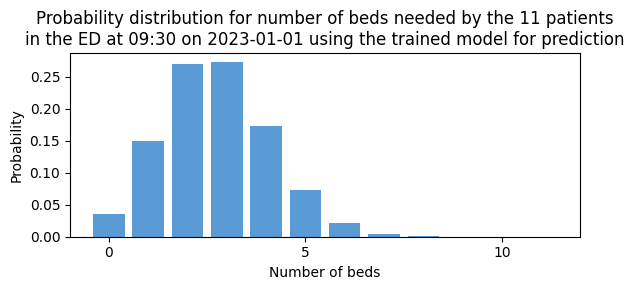

In [12]:
from patientflow.viz.probability_distribution import plot_prob_dist
from patientflow.viz.utils import format_prediction_time
title = (
    f'Probability distribution for number of beds needed by the '
    f'{len(first_snapshot_X)} patients\n'
    f'in the ED at {format_prediction_time((9,30))} '
    f'on {first_group_snapshot_key} using the trained model for prediction'
)
plot_prob_dist(bed_count_prob_dist['agg_predicted'], title,  
    include_titles=True)


The `plot_prob_dist` function will return the figure if requested. For example below, I have added the observed number of admissions for this group snapshot to the figure. 

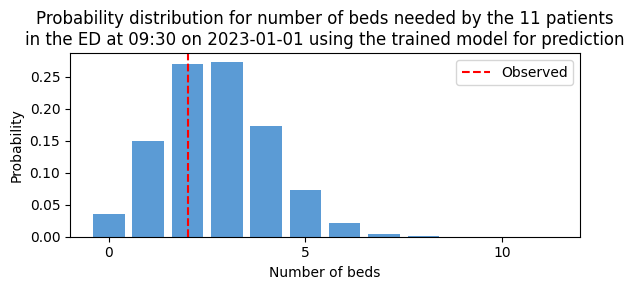

In [13]:
fig = plot_prob_dist(bed_count_prob_dist['agg_predicted'], title,  
    include_titles=True, return_figure=True)
ax = fig.gca()  
ax.axvline(x=bed_count_prob_dist['agg_observed'], color='red', linestyle='--', label='Observed')
ax.legend();


## Make predictions for group snapshots

Now we'll make predictions for the whole test set. 

In [ ]:
X_test, y_test = prepare_patient_snapshots(
    df=snapshots_df, 
    prediction_time=(9,30), 
    single_snapshot_per_visit=False,
    # exclude_columns=exclude_from_training_data, now deprecated; 
    visit_col='visit_number'
)

Note - the exclude_from_training_data parameter in the above is not needed, as the information relating to which columns should be excluded has been retained within the model object

The `get_prob_dist` function is set up to receive as input a dictionary of group snapshots, created using the `prepare_group_snapshot_dict` function demonstrated above. It calls `get_prob_dist_for_prediction_moment()` for each entry in the dictionary. The arguments to `get_prob_dist` are: 

* `snapshots_dict` - a snapshots dictionary
* `X_test` - the dataset of patient snapshots to be passed to the model
* `y_test` - the vector containing the outcome for each patient snapshot
* `model` - a trained model
* `weights` - an optional parameter to weight the probabilities returned by the model. This will be demonstrated in later examples

When calling `get_prob_dist_for_prediction_moment` the function will set the `inference_time` parameter to false. 

In [28]:
from patientflow.aggregate import get_prob_dist

group_snapshots_dict = prepare_group_snapshot_dict(
    test_visits[test_visits.prediction_time == (9,30)]
    )
# get probability distribution for this time of day
prob_dists_for_group_snapshots = get_prob_dist(
        group_snapshots_dict, X_test, y_test, model
    )

In the next cell I pick a date from the test set at random, and visualise the predicted distribution. 

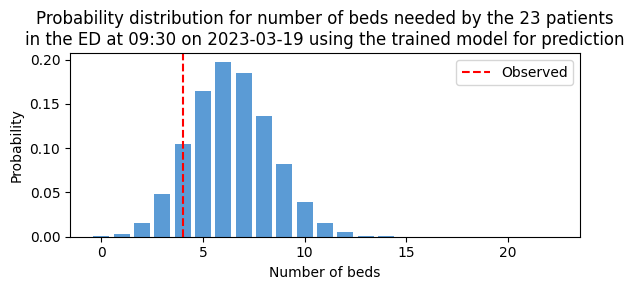

In [29]:
import random
random_snapshot_date = random.choice(list(prob_dists_for_group_snapshots.keys()))
title = (
    f'Probability distribution for number of beds needed by the '
    f'{len(prob_dists_for_group_snapshots[random_snapshot_date]["agg_predicted"])} patients\n'
    f'in the ED at {format_prediction_time((9,30))} '
    f'on {random_snapshot_date} using the trained model for prediction'
)
fig = plot_prob_dist(prob_dists_for_group_snapshots[random_snapshot_date]['agg_predicted'], title,  
    include_titles=True, return_figure=True)
ax = fig.gca()  
ax.axvline(x=prob_dists_for_group_snapshots[random_snapshot_date]['agg_observed'], color='red', linestyle='--', label='Observed')
ax.legend();

The returned object is now ready for evaluation, which I cover in the next notebook. 

## Summary

In this notebook I have demonstrated the functions in `patientflow` that handle the preparation of group snapshots. These include: 

* `prepare_patient_snapshots`, which makes the data ready for processing in groups.
* `get_prob_dist_for_prediction_moment`, which computes predicted and observed probabilities for a specific snapshot date and prediction time.
* `get_prob_dist` which computes probability distributions for multiple snapshot dates.

I have also shown the use of `plot_prob_dist` to visualise the predicted distribution for one group snapshot.